In [1]:
import googlemaps
import datetime
import pandas as pd
import numpy as np
from numpy import cos, sin, arcsin, sqrt
from math import radians
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('.api_key', 'r') as fobj:
    key = fobj.read().strip()

gmaps = googlemaps.Client(key=key)
COORDINATES_AACHEN = [50.775429, 6.081490]

df_auto = pd.read_excel('../data/data.xlsx', header=[0,1]).drop(index=0).reindex(columns=['origin', 'destination','transit'], level=0)
df_bus1 = pd.read_excel('../data/data_bus.xlsx', header=[0,1]).drop(index=0).reindex(columns=['origin', 'destination', 'transit'], level=0)

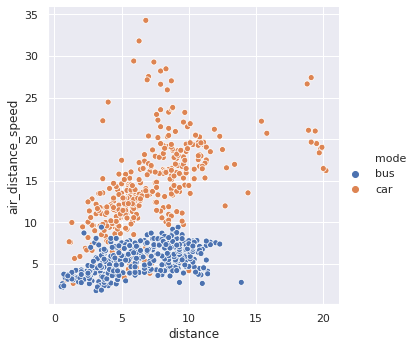

In [3]:
df_car = df_auto.copy().iloc[1:370]
df_bus = df_bus1.copy().iloc[1:370]

def rename_cols(df):
    df.columns = df.columns.droplevel()
    df.columns = ['org_lat', 'org_lon', 'dest_lat', 'dest_lon'] + df.columns.to_list()[4:]
    return df

df_car = rename_cols(df_car)
df_bus = rename_cols(df_bus)

df_car = df_car.loc[(df_car['distance'].notnull()) & (df_car['duration'] > 1)]
df_bus = df_bus.loc[df_bus['distance'].notnull() & (df_bus['duration'] > 1)]

def haversine(x):
    lon1 = x['org_lon']
    lat1 = x['org_lat']
    lon2 = x['dest_lon']
    lat2 = x['dest_lat']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km


def calc_indicators(df):
    df['air_distance'] = df.apply(lambda row: haversine(row), axis=1)

    df['air_distance_speed'] = (df['air_distance'] / df['duration']) * 60
    df['umwegfaktor'] = df['distance'] / df['air_distance']
    return df


df_car = calc_indicators(df_car)
df_bus = calc_indicators(df_bus)


def transform(df_car, df_bus):
    dfc = df_car.copy()
    dfb = df_bus.copy()
    
    cols = ['distance','duration' ,'air_distance', 'air_distance_speed', 'umwegfaktor', 'mode']
    
    dfc['mode'] = 'car'
    dfb['mode'] = 'bus'
    
    df = dfc.reindex(columns=cols).append(dfb.reindex(columns=cols), ignore_index=True)
    df = df.assign(mode=pd.Categorical(df['mode']))
    
    return df
    
df_t = transform(df_car, df_bus)

sns.set()
#sns.relplot(x='distance', y='duration', hue='air_distance_speed', data=df_bus)
f = sns.relplot(x='distance', y='air_distance_speed', hue='mode', data=df_t)
f.savefig('new.png')
plt.show()

In [7]:
import plotly.graph_objects as go

indicator = 'air_distance_speed' 

df = df_bus.copy()

fig = go.Figure()

fig = go.Figure(go.Scattermapbox(
        lat=df.loc[:,'org_lat'],
        lon=df.loc[:,'org_lon'],
        mode='markers',
        showlegend=False,
        marker=dict(
            size = 45,
            opacity = 0.3,
            reversescale = False,
            autocolorscale = False,
            colorscale = 'RdYlGn',
            cmin = df[indicator].min(),
            color = df[indicator],
            cmax = df[indicator].max(),
            colorbar_title="km/h"
        )
    ))

fig.add_trace(go.Scattermapbox(
        lat=[df.loc[10, 'dest_lat']],
        lon=[df.loc[10, 'dest_lon']],
        mode='markers',
        showlegend=False,
        marker=go.scattermapbox.Marker(
            size=20,
            color="rgb(175, 7,7)",
            symbol='harbor'
        ),
        text=['Ziel'],
    ))


fig.update_layout(
    hovermode='closest',
    autosize=False,
    mapbox_style='streets',
    width=1000,
    height=950,
    mapbox=go.layout.Mapbox(
        accesstoken=open(".mapbox_token").read(),
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=COORDINATES_AACHEN[0],
            lon=COORDINATES_AACHEN[1],
        ),
        pitch=0,
        zoom=12.2
    )
)

fig.show()

In [18]:
def create_location_matrix(minX, maxX, minY, maxY):
    campus_melaten = (50.781934, 6.04716)

    # define the lower and upper limits for x and y
    minX, maxX, minY, maxY = 50.740252, 50.804145, 6.025887, 6.141934
    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, num=20)
    y = np.linspace(minY, maxY, num=20)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)

    X = X.reshape((np.prod(X.shape),))
    Y = Y.reshape((np.prod(Y.shape),))

    dest = list(zip(X, Y))

    dest_lat = [x[0] for x in dest]
    dest_lng = [x[1] for x in dest]
    
    return dest_lat, dest_lng

def build_df(dest_lat, dest_lng):
    columns = pd.MultiIndex.from_product([['origin', 'destination'],['lat', 'lng']])
    df_tmp = pd.DataFrame(1,index=list(range(1,len(dest_lat) + 1)),columns=columns)
    df_tmp.index = df_tmp.index.set_names('id')
    df_tmp[('destination','lat')] = [campus_melaten[0]] * len(df_tmp)
    df_tmp[('destination','lng')] = [campus_melaten[1]] * len(df_tmp)
    df_tmp[('origin','lat')] = dest_lat
    df_tmp[('origin','lng')] = dest_lng
    
    return df_tmp

def split_df(df_tmp):
    i1 = 0
    elemente = list()
    for i in range(25, len(df_tmp) ,25):
        df = df_tmp.iloc[i1:i]
        origin = list(zip(df[('destination','lat')].values.tolist(), df[('destination','lng')].values.tolist()))[1]
        destination = list(zip(df[('origin','lat')].values.tolist(), df[('origin','lng')].values.tolist()))
        matrix = gmaps.distance_matrix(origins=origin, destinations=destination, mode='transit', departure_time=time)
        elemente.extend(matrix.get('rows'))
        i1=i
    return elemente

def append_to_df(df_tmp, elem):
    
    i1 = 0
    n = +0
    
    for i in range(25, len(df_tmp), 25):
        durations = list()
        length = list()
        for x in elem[n].get('elements'):
            if x.get('status') == 'OK':
                durations.append(x.get('duration').get('text').replace(' hour ',':').replace(' mins','').replace(' min', ''))
                length.append(x.get('distance').get('text').split(' ')[0])
            else:
                durations.append(np.nan)
                length.append(np.nan)
                
            
        df_tmp.loc[i1+1:i,('transit', 'duration')] = durations
        df_tmp.loc[i1+1:i,('transit', 'distance')] = length

        values = df_tmp.loc[i1+1:i,('transit', 'duration')].str.split(':', expand=True).fillna(0).astype(int)
        if len(values.columns) > 1:
            values[1] = np.where(values[1] == 0, values[0], values[1])
            values[0] = np.where(values[0] == values[1], 0, values[0])
            factors = np.array([60, 1])
            df_tmp.loc[i1+1:i,('transit', 'duration')] = (values * factors).sum(1)
        else:
            df_tmp.loc[i1+1:i,('transit', 'duration')] = values[0]
    
        i1 = i
        n += 1
        
    return df_tmp

dest_lat, dest_lng = create_location_matrix(50.740252, 50.804145, 6.025887, 6.141934)
#df_tmp = build_df(dest_lat, dest_lng)
#matrix = split_df(df_tmp)
#df_tmp = append_to_df(df_tmp, matrix)
#df_tmp.to_excel('data_bus.xlsx')
df_bus

origin           destination           transit         
           lat       lng         lat      lng duration distance
1    50.740252  6.025887   50.781934  6.04716     91.0     13.2
2    50.743615  6.025887   50.781934  6.04716     97.0     13.9
3    50.746978  6.025887   50.781934  6.04716      0.0      NaN
4    50.750340  6.025887   50.781934  6.04716     52.0      8.5
5    50.753703  6.025887   50.781934  6.04716     56.0      4.1
..         ...       ...         ...      ...      ...      ...
396  50.790694  6.141934   50.781934  6.04716      NaN      NaN
397  50.794057  6.141934   50.781934  6.04716      NaN      NaN
398  50.797419  6.141934   50.781934  6.04716      NaN      NaN
399  50.800782  6.141934   50.781934  6.04716      NaN      NaN
400  50.804145  6.141934   50.781934  6.04716      NaN      NaN

[400 rows x 6 columns]

In [36]:


df[('transit','air_distance')] = df.apply(lambda row: haversine(row), axis=1)
df_bus[('transit', 'air_distance')] = df_bus.apply(lambda row: haversine(row), axis=1)
df

origin           destination           transit            distance
           lat       lng         lat      lng duration  distance          
1    50.740252  6.025887   50.781934  6.04716     91.0  4.867308  4.867308
2    50.743615  6.025887   50.781934  6.04716     97.0  4.513133  4.513133
3    50.746978  6.025887   50.781934  6.04716      0.0  4.162372  4.162372
4    50.750340  6.025887   50.781934  6.04716     52.0  3.815966  3.815966
5    50.753703  6.025887   50.781934  6.04716     56.0  3.475218  3.475218
..         ...       ...         ...      ...      ...       ...       ...
366  50.757066  6.135826   50.781934  6.04716     55.0  6.816749  6.816749
367  50.760429  6.135826   50.781934  6.04716     49.0  6.673796  6.673796
368  50.763792  6.135826   50.781934  6.04716     56.0  6.549072  6.549072
369  50.767154  6.135826   50.781934  6.04716     54.0  6.443633  6.443633
370  50.770517  6.135826   50.781934  6.04716     52.0  6.358441  6.358441

[370 rows x 7 columns]